In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46315")
client

<Client: 'tcp://127.0.0.1:46315' processes=4 threads=4, memory=32.00 GiB>

Task exception was never retrieved
future: <Task finished name='Task-7807' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-8100' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-5800' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/pyth

In [2]:
import xarray as xr

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgcm
from typing import Annotated
from xhistogram.xarray import histogram

In [3]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid

In [4]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [5]:
grid = xgcm.Grid(ds_grid, periodic=False)

In [6]:



@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [7]:
def vort_strain_div_bins(n_strain_bins=100, n_vort_bins=200, n_div_bins=200, vort_max=5, strain_max=5, div_max=5):
    vort_bins = np.linspace(-vort_max, vort_max, n_vort_bins)
    strain_bins = np.linspace(0.0, strain_max, n_strain_bins)
    div_bins = np.linspace(-div_max, div_max, n_div_bins)
    return vort_bins, strain_bins, div_bins

In [8]:
vort_bins, strain_bins, div_bins = vort_strain_div_bins(n_strain_bins=50, n_vort_bins=100, n_div_bins=100)
a = np.diff(vort_bins)[0]*np.diff(strain_bins)[0]*np.diff(div_bins)[0]

In [9]:
ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [10]:
tdiff = 240
tstep=24
σ_piece = σ.isel(time=slice(2736,2736+tdiff,tstep)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece = ζ.isel(time=slice(2736,2736+tdiff,tstep)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece = D.isel(time=slice(2736,2736+tdiff,tstep)).sel(face=1).isel(i=slice(0,550)).isel(j=slice(1100,1650))/10**-4

In [11]:
ds.sel(face=1).YC.isel(i=slice(0,550)).isel(j=slice(1100,1650)).min().values

array(-43.23789, dtype=float32)

In [12]:
h = histogram(
    ζ_piece.rename('vort'),
    σ_piece.rename('strain'),
    D_piece.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h = h/a/550/550

In [13]:
h_DivPdf = (h*h.div_bin).mean('div_bin').load()

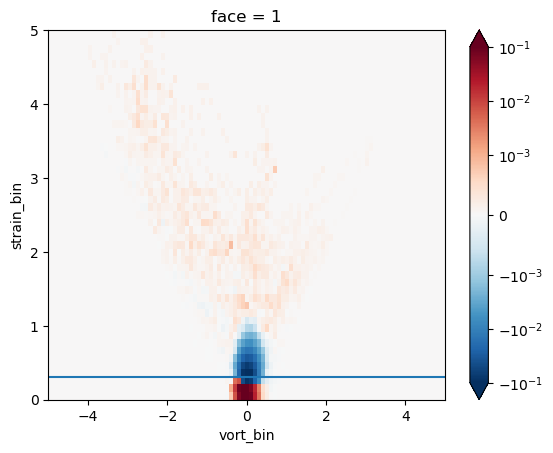

In [14]:
h_DivPdf.plot(x='vort_bin', vmax=0.1, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)

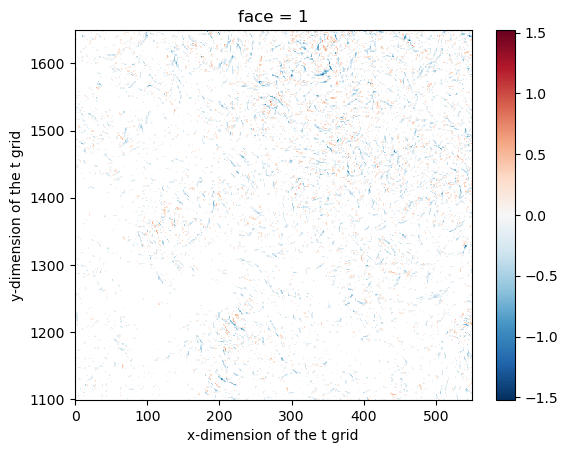

In [15]:
D_piece.where((σ_piece>0.3)& (np.abs(ζ_piece)<0.3)).isel(time=0).plot()

In [16]:
def sinc2(x, a):
        return np.sinc(x/a)
window_width=30
f=0.8*10**-4
weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2),np.expand_dims(np.pi/f/3600,0)*1.1), dims=['window'])
u_filt = ds.U.sel(face=1).isel(i_g=slice(0,550)).isel(j=slice(1100,1650),time=slice(0,1000)).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')


In [35]:
#This isn't working yet. 
ds_sec = ds.sel(face=1).isel(i=slice(0,550)).isel(i_g=slice(0,550)).isel(j=slice(1100,1650)).isel(j_g=slice(1100,1650))
def sinc2(x, a):
        return np.sinc(x/a)
window_width=30
f=0.8*10**-4
weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2),np.expand_dims(np.pi/f/3600,0)*1.1), dims=['window'])
u_filt = ds_sec.U.isel(time=slice(2736,2736+tdiff,tstep)).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_filt = ds_sec.V.isel(time=slice(2736,2736+tdiff,tstep)).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
#u_filt = ds.U.rolling(time=20).mean()
u_pert = ds_sec.U.isel(time=slice(2736,2736+tdiff,tstep)) - u_filt
#v_filt = ds.V.rolling(time=20).mean()
v_pert = ds_sec.V.isel(time=slice(2736,2736+tdiff,tstep)) - v_filt

/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/core.py:5039: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [57]:
grid1 = xgcm.Grid(ds_sec.isel(time=slice(2736,2736+tdiff,tstep)), periodic=False)

In [54]:
v_pert*xr.ones_like(ds_sec.V)

<xarray.DataArray (time: 10, j_g: 550, i: 550)> Size: 24MB
dask.array<multiply, shape=(10, 550, 550), dtype=float64, chunksize=(1, 550, 550), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 80B 2012-01-05 2012-01-06 ... 2012-01-14
  * i        (i) int64 4kB 0 1 2 3 4 5 6 7 8 ... 542 543 544 545 546 547 548 549
  * j_g      (j_g) int64 4kB 1100 1101 1102 1103 1104 ... 1646 1647 1648 1649
    face     int64 8B 1

In [68]:
ζ_pert = vort(grid1, u_pert*xr.ones_like(ds_sec.U), ds_sec.dxC, v_pert*xr.ones_like(ds_sec.V), ds_sec.dyC, ds_sec.rAz, axis= 5 * [("Y", "X")])
#σ_pert = strain(grid1, u_pert*xr.ones_like(ds_sec.U), ds_sec.dxC, v_pert*xr.ones_like(ds_sec.V), ds_sec.dyC, axis=4 * [("Y", "X")])
#D_pert = divergence(grid, u_pert*xr.ones_like(ds_sec.U), ds_sec.dxG, v_pert*xr.ones_like(ds_sec.V), ds_sec.dyG, ds_sec.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 23.09 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 23.09 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


KeyError: 'i_g'

In [66]:
ζ_pert

<xarray.DataArray (time: 10, j_g: 550, i_g: 550)> Size: 24MB
dask.array<transpose, shape=(10, 550, 550), dtype=float64, chunksize=(1, 550, 550), chunktype=numpy.ndarray>
Coordinates:
    face     int64 8B 1
  * i_g      (i_g) int64 4kB 0 1 2 3 4 5 6 7 ... 542 543 544 545 546 547 548 549
  * time     (time) datetime64[ns] 80B 2012-01-05 2012-01-06 ... 2012-01-14
  * j_g      (j_g) int64 4kB 1100 1101 1102 1103 1104 ... 1646 1647 1648 1649

In [63]:
tdiff = 240
tstep=24
σ_piece_pert = σ_pert.rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece_pert = ζ_pert.rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece_pert = D_pert/10**-4

In [65]:
D_piece_pert#.where((σ_piece_pert>0.3)& (np.abs(ζ_piece_pert)<0.3)).isel(time=0).plot()

<xarray.DataArray (time: 10, j: 4320, i: 4320)> Size: 1GB
dask.array<truediv, shape=(10, 4320, 4320), dtype=float64, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
Dimensions without coordinates: time

In [ ]:
(D_piece.where((σ_piece>0.3)& (np.abs(ζ_piece)<0.3)).isel(time=0)
 -D_piece_pert.where((σ_piece_pert>0.3)& (np.abs(ζ_piece_pert)<0.3)).isel(time=0)).plot()

In [ ]:
h_pert = histogram(
    ζ_piece_pert.rename('vort'),
    σ_piece_pert.rename('strain'),
    D_piece_pert.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h_pert = h_pert/a/550/550

In [ ]:
h_DivPdf_pert = (h_pert*h_pert.div_bin).mean('div_bin').load()

In [ ]:
h_DivPdf_pert.plot(x='vort_bin', vmax=0.1, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)

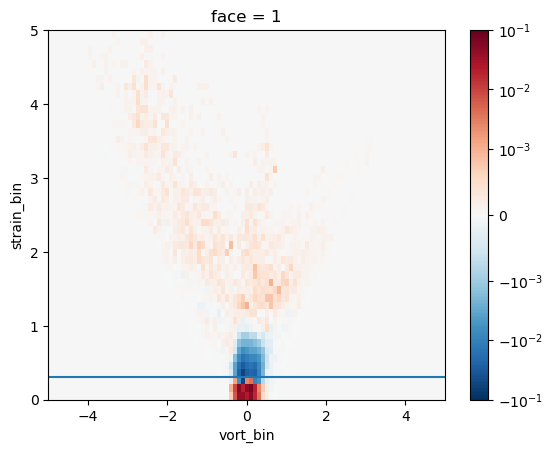

In [21]:
(h_DivPdf-h_DivPdf_pert).plot(x='vort_bin', vmax=0.1, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)